# Goals

The purpose of this analysis is to provide a method for early identification of students at risk of failing. This is vital for any learning platforms, especially online ones. The data used is the [Open University Learning Analytics dataset (OULAD)](https://analyse.kmi.open.ac.uk/open_dataset).  

# Data Exploration

In [1]:
# import

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

In [2]:
# csv to pd frame 

csv_path = '../input/student-demographics-online-education-dataoulad/'
data_dicts = {csv_name[:-4]: pd.read_csv(csv_path+csv_name) for csv_name in os.listdir(csv_path)}

First let's take a look at each dataset separately. 

## courses.csv


In [3]:
data_dicts['courses'].groupby(['code_module','code_presentation']).agg(['min','max'])

module_presentation_length     
                                                     min  max
code_module code_presentation                                
AAA         2013J                                    268  268
            2014J                                    269  269
BBB         2013B                                    240  240
            2013J                                    268  268
            2014B                                    234  234
            2014J                                    262  262
CCC         2014B                                    241  241
            2014J                                    269  269
DDD         2013B                                    240  240
            2013J                                    261  261
            2014B                                    241  241
            2014J                                    262  262
EEE         2013J                                    268  268
            2014B                                    241  241
            2014J                                    269  269
FFF         2013B                                    240  240
            2013J                                    268  268
            2014B                                    241  241
            2014J                                    269  269
GGG         2013J                                    261  261
            2014B                                    241  241
            2014J                                    269  269

According to the data's documentation, there are 8 courses (modules) recorded, from A to G (AAA in dataset, henceforth shortened to A). There are 2 semesters recorded, February (B) and October (J). February semesters are typically 20 days shorter then October ones. Some courses (C,E,G) don't have data for both 2013 and 2014. 

## assessments.csv

In [4]:
df = data_dicts['assessments']
df.drop(['date','weight'],axis = 1).groupby(['code_module','assessment_type','code_presentation']).count()

id_assessment
code_module assessment_type code_presentation               
AAA         Exam            2013J                          1
                            2014J                          1
            TMA             2013J                          5
                            2014J                          5
BBB         CMA             2013B                          5
                            2013J                          5
                            2014B                          5
            Exam            2013B                          1
                            2013J                          1
                            2014B                          1
                            2014J                          1
            TMA             2013B                          6
                            2013J                          6
                            2014B                          6
                            2014J                          5
CCC         CMA             2014B                          4
                            2014J                          4
            Exam            2014B                          2
                            2014J                          2
            TMA             2014B                          4
                            2014J                          4
DDD         CMA             2013B                          7
            Exam            2013B                          1
                            2013J                          1
                            2014B                          1
                            2014J                          1
            TMA             2013B                          6
                            2013J                          6
                            2014B                          6
                            2014J                          6
EEE         Exam            2013J                          1
                            2014B                          1
                            2014J                          1
            TMA             2013J                          4
                            2014B                          4
                            2014J                          4
FFF         CMA             2013B                          7
                            2013J                          7
                            2014B                          7
                            2014J                          7
            Exam            2013B                          1
                            2013J                          1
                            2014B                          1
                            2014J                          1
            TMA             2013B                          5
                            2013J                          5
                            2014B                          5
                            2014J                          5
GGG         CMA             2013J                          6
                            2014B                          6
                            2014J                          6
            Exam            2013J                          1
                            2014B                          1
                            2014J                          1
            TMA             2013J                          3
                            2014B                          3
                            2014J                          3

Course C have 2 final exams. Course A doesn't have any Computer Marked Assessment (CMA). Each course has at least 3 TMAs.

In [5]:
df.drop(['id_assessment'],axis = 1).groupby(['code_module','assessment_type','code_presentation']).agg(['min','max'])

date        weight       
                                                 min    max    min    max
code_module assessment_type code_presentation                            
AAA         Exam            2013J                NaN    NaN  100.0  100.0
                            2014J                NaN    NaN  100.0  100.0
            TMA             2013J               19.0  215.0   10.0   30.0
                            2014J               19.0  215.0   10.0   30.0
BBB         CMA             2013B               54.0  187.0    1.0    1.0
                            2013J               54.0  208.0    1.0    1.0
                            2014B               47.0  194.0    1.0    1.0
            Exam            2013B                NaN    NaN  100.0  100.0
                            2013J                NaN    NaN  100.0  100.0
                            2014B                NaN    NaN  100.0  100.0
                            2014J                NaN    NaN  100.0  100.0
            TMA             2013B               19.0  187.0    5.0   18.0
                            2013J               19.0  208.0    5.0   18.0
                            2014B               12.0  194.0    5.0   18.0
                            2014J               19.0  201.0    0.0   35.0
CCC         CMA             2014B               18.0  207.0    2.0    8.0
                            2014J               18.0  214.0    2.0    8.0
            Exam            2014B                NaN    NaN  100.0  100.0
                            2014J                NaN    NaN  100.0  100.0
            TMA             2014B               32.0  200.0    9.0   22.0
                            2014J               32.0  207.0    9.0   22.0
DDD         CMA             2013B               23.0  206.0    2.0    6.0
            Exam            2013B              240.0  240.0  100.0  100.0
                            2013J              261.0  261.0  100.0  100.0
                            2014B              241.0  241.0  100.0  100.0
                            2014J                NaN    NaN  100.0  100.0
            TMA             2013B               25.0  200.0    7.5   15.0
                            2013J               25.0  207.0   10.0   20.0
                            2014B               25.0  200.0   10.0   20.0
                            2014J               20.0  195.0    5.0   25.0
EEE         Exam            2013J              235.0  235.0  100.0  100.0
                            2014B              228.0  228.0  100.0  100.0
                            2014J              235.0  235.0  100.0  100.0
            TMA             2013J               33.0  159.0   16.0   28.0
                            2014B               33.0  152.0   16.0   28.0
                            2014J               33.0  166.0   16.0   28.0
FFF         CMA             2013B              222.0  222.0    0.0    0.0
                            2013J              236.0  236.0    0.0    0.0
                            2014B              227.0  227.0    0.0    0.0
                            2014J              241.0  241.0    0.0    0.0
            Exam            2013B              222.0  222.0  100.0  100.0
                            2013J              236.0  236.0  100.0  100.0
                            2014B              227.0  227.0  100.0  100.0
                            2014J              241.0  241.0  100.0  100.0
            TMA             2013B               19.0  166.0   12.5   25.0
                            2013J               19.0  173.0   12.5   25.0
                            2014B               24.0  171.0   12.5   25.0
                            2014J               24.0  199.0   12.5   25.0
GGG         CMA             2013J              229.0  229.0    0.0    0.0
                            2014B              222.0  222.0    0.0    0.0
                            2014J              229.0  229.0    0.0    0.0
            Exam            2013J              229.0

According to data's documentation, exams have weight 100, and all the other assignments have weights adding up to 100. However, this is not true for all courses. In course G, only exams have weight. Additionally, course G has all CMAs on the same date. Course G is also abnormal in term of assignment date: all the other courses have first assignment within the first 30 days, but first assignment for course G is on day 61. Finally, final exam dates are missing, but this can be collected from the `courses.csv` dataset. 

## vle.csv

In [6]:
df = data_dicts['vle']
df.head()
#sum(df['week_from'].isnull())/df.shape[0]

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


`week_from` and `week_to` tell us the timeframe certain contents are supposed to be used. Unfortunately, over 82% of this content is missing from the dataset.

## studentInfo.csv

In [7]:
df = data_dicts['studentInfo']
df.head()
# df['imd_band'].isnull().sum()
# columns = df.columns[3:]
# for column in columns:
#     print(df[column].value_counts(),'\n')

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [8]:
print('Number of missing entries per column:')
df.isnull().sum()

Number of missing entries per column:


code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64

There are 1000 observations with `imd_band` (Index of Multiple Depravation, an index for living condition) missing. Something we might want to consider when building model later. 

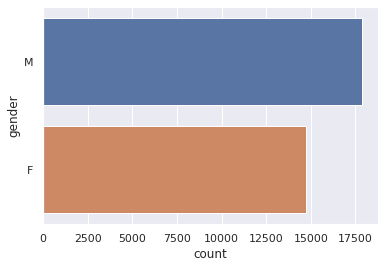

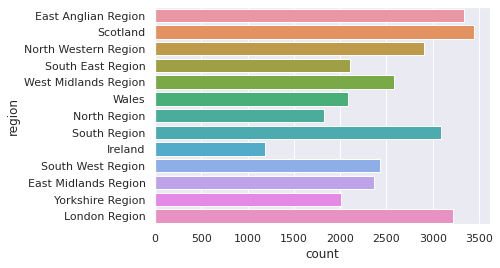

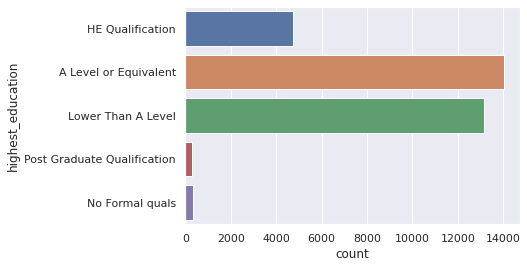

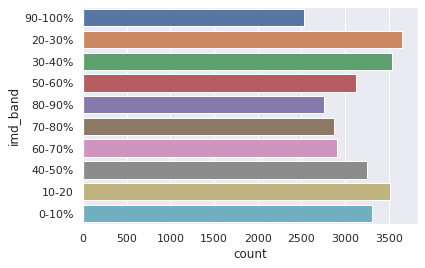

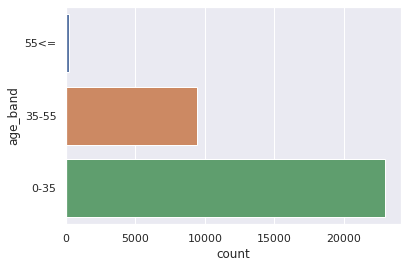

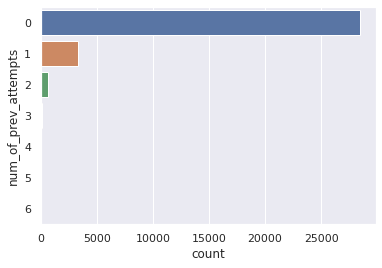

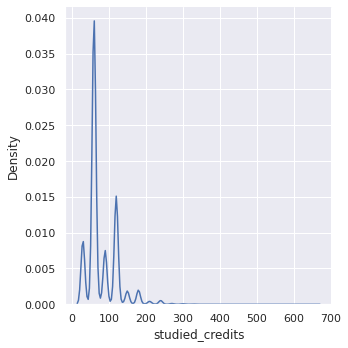

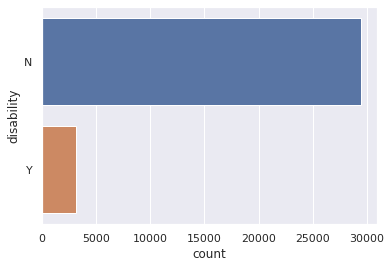

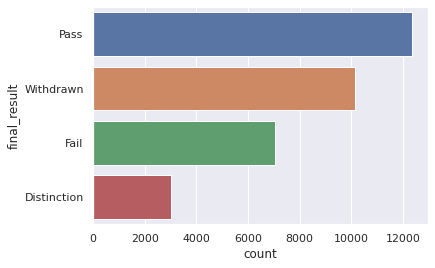

In [9]:
sns.set_theme(style="darkgrid")
for i, column in enumerate(df.columns):
    if i>2 and i != 9:
        sns.countplot(y = column, data = df)
        plt.show()
    elif i == 9: 
        sns.displot(x = column, data = df, kind="kde")
        plt.show()

Certain features such as `studied_credits`, `num_of_prev_attempts`, `age_band`, `highest_education` contain some extreme observations. It's not really a problem for our analysis, since we are going to use Random Forest.  

## studentRegistration.csv

In [10]:
df = data_dicts['studentRegistration']
df.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


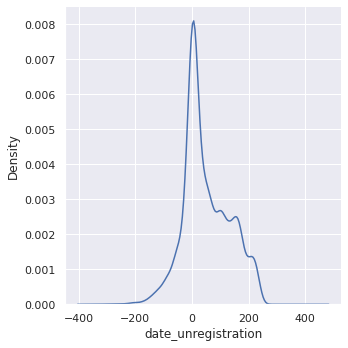

In [11]:
sns.displot(x = 'date_unregistration', data = df, kind="kde")
plt.show()

From the plot, we can see that there are a decent amount of students who withdrew from a course before it started. We will remove these students from our dataset later, since we don't have any academic performance data for them.  

## studentAssessment.csv

In [12]:
df = data_dicts['studentAssessment']
df.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [13]:
print('Number of missing entries per column:')
df.isnull().sum()

Number of missing entries per column:


id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

According to the data's documentation, score ranges from 0 to 100. Score lower than 40 is interpreted as a Fail. If the student does not submit the assessment, no result is recorded. Most of the missing scores are from final exams, which does not impact our analysis, since we are only concern with students' performance early in the semester.

# Prepping the Data for Analysis

In [14]:
# function for merging 2 pandas dataframes

def inner_merge(left_df,right_df,right_cols,on_cols):
    right_df = right_df[right_cols]
    left_df = left_df.merge(right_df, on = on_cols)
    return left_df.drop_duplicates()

We want to predict a student's final result based on their early performance. By performance, we mean 2 things: academic performance, measured via the students' scores, and academic engagement, measured via the number of times the students click on course content. The three variables below control how many days into a semester we want to include for our analysis.  

In [15]:
score_deadline = 90
click_deadline = 90
withdraw_deadline = 90

Below we have a function that creates a dataset that contains each student's average assignment score within the first `score_deadline` days. Another function to create a dataset that contains each student's average number of clicks for each resource category within the first `click_deadline` days. Then a function to merge the two datasets together, as well as remove students who withdrew before `withdraw_deadline`. Since our analysis only concerns with Pass/Fail, we merge Distinction final results into Pass, and merge Withdrawn into Fail. The idea is that after a certain amount of time, the only people who withdraw are the people who are concerned with their performance, and are less likely to withdraw due to non-academic related reasons. 

In [16]:
# score data

def create_score_df(score_deadline):

    df1 = data_dicts['assessments']
    df2 = data_dicts['studentAssessment']

    score_df = inner_merge(df1,
                           df2,
                           df2.columns,
                           ['id_assessment'],
                          )

    score_df = score_df[score_df['date'] < score_deadline]

    score_df = score_df[score_df['assessment_type'] != 'Exam']

    score_df = score_df.dropna(subset = ['score']) 

    score_df.isnull().sum()

    score_df['assessment_type'].value_counts()

    score_df = score_df.groupby(['code_module', 'code_presentation', 'id_student']).mean().reset_index()
    score_df = score_df.rename(columns = {'score': f'mean_score_day{score_deadline}'})
    score_df = score_df.drop(['date', 'weight', 
                              'date_submitted', 'is_banked',
                              'id_assessment'],
                             axis = 1)
    return score_df

In [17]:
# click data

def create_click_df(click_deadline):

    clicks = data_dicts['studentVle']

    clicks = inner_merge(clicks,
                         data_dicts['vle'],
                         ['id_site','code_module','code_presentation','activity_type'],
                         ['id_site','code_module','code_presentation'],
                        )

    clicks = clicks.drop('id_site', axis = 1)

    def clicks_xx(clicks,xx):
        temp = clicks[clicks['date'] <= xx]
        temp = temp.drop('date', axis = 1)
        temp = temp.groupby(['code_module','code_presentation','id_student','activity_type']).mean()
        temp = temp.rename(columns = {'sum_click': f'sum_click{xx} mean'})
        temp = temp.reset_index() # this fills out the missing columns for merging later 
        return temp

    click_data = pd.pivot_table(data = clicks_xx(clicks,click_deadline), 
                                index = ['code_module','code_presentation','id_student'],
                                columns = 'activity_type', 
                                values = [f'sum_click{click_deadline} mean'],
                                fill_value = 0,
                               ).reset_index()

    # get rid of multi index
    click_data = pd.concat([click_data['code_module'],
                            click_data['code_presentation'],
                            click_data['id_student'], 
                            click_data[f'sum_click{click_deadline} mean']], axis=1)
    return click_data

In [18]:
# merge score_df and click_df
def create_final_df(withdraw_deadline, score_df, click_df):

    final_df = inner_merge(click_df, # merge with StudentInfo
                           data_dicts['studentInfo'],
                           data_dicts['studentInfo'].columns,
                           ['code_module', 'code_presentation', 'id_student'],
                          )

    final_df = final_df.replace('Distinction','Pass') # merge Pass and Distinction

    final_df = inner_merge(final_df, 
                           data_dicts['studentRegistration'],
                           ['code_module', 'code_presentation', 'id_student', 'date_unregistration'],
                           ['code_module', 'code_presentation', 'id_student'],
                          )

    final_df = final_df[(final_df['final_result'] != 'Withdrawn') | # remove people who withdrew before withdraw_deadline
                       (final_df['date_unregistration'] > withdraw_deadline)]

    final_df = final_df.reset_index()

    final_df = final_df.drop(['date_unregistration','index'],axis = 1)

    final_df = inner_merge(final_df,
                           score_df,
                           score_df.columns,
                           ['code_module', 'code_presentation', 'id_student'])
    
    final_df = final_df.replace('Withdrawn','Fail') # merge Withdrawn to Fail

    return final_df

In [19]:
score_df = create_score_df(score_deadline)
click_df = create_click_df(click_deadline)
final_df = create_final_df(withdraw_deadline, score_df, click_df)
final_df.head()

,code_module,code_presentation,id_student,dataplus,dualpane,externalquiz,forumng,glossary,homepage,htmlactivity,...,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,mean_score_day90
0,AAA,2013J,11391,0.0,0.0,0.0,3.514286,0.0,3.478261,0.0,...,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,81.5
1,AAA,2013J,28400,0.0,0.0,0.0,2.988889,0.0,5.194444,0.0,...,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,69.0
2,AAA,2013J,31604,0.0,0.0,0.0,2.955882,1.0,4.340000,0.0,...,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,71.5
3,AAA,2013J,32885,0.0,0.0,0.0,3.127660,2.0,3.600000,0.0,...,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,49.5
4,AAA,2013J,38053,7.0,0.0,0.0,3.457364,0.0,4.438596,0.0,...,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,74.0


Finally we do some touch-ups to the dataframe before feeding it to our model. First we want to encode all the categorical variables. Here we do label encoding instead of one-hot encoding, simply because it works for tree-based algorithms, and it's easier to read if later we want to visually inspect individual trees. 

In [20]:
def create_Xy(final_df):

    X = final_df.drop(['final_result','id_student','imd_band'],axis = 1)
    column_names = X.columns
    y = final_df['final_result']

    le = LabelEncoder()
    encode_dict = {}
    Xcat_features = ['code_module', 'code_presentation',
                    'gender', 'region',
                    'highest_education',  
                    'age_band','disability',
                   ]

    for cat_feature in Xcat_features: 
        X[cat_feature] = le.fit_transform(X[cat_feature])
        encode_dict[cat_feature] = le.classes_

    y = le.fit_transform(y)
    encode_dict['final_result'] = le.classes_

    X = X.to_numpy()
    
    return X,y,column_names,encode_dict

In [21]:
X,y,column_names,encode_dict = create_Xy(final_df)

We also want to handle potential collinearity in the data. While collinearity does not impact Random Forest model per se, it might negatively affect the feature importance analysis we do after. 

In [22]:
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X = X[:, selected_features]
column_names = column_names[selected_features]

# Modeling 

Here we use Random Forest simply because it's a good model for classification on tabular data. It's also good out-of-the-box, i.e. not a lot of fussing over hyperparameters. Moreover, there is a straight-forward implementation for permutation feature importance.  

In [23]:
reg = RandomForestClassifier(n_estimators = 200,
                             max_features = 'sqrt', 
                             min_samples_split = 10, 
                            )

kf = KFold(n_splits=5, shuffle = True)

def train(X,y,reg,kf):
    if kf == False: 
        reg.fit(X,y)
    else:
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            reg.fit(X_train,y_train)
            print(f'evaluate score: {reg.score(X_test,y_test)}')

In [24]:
train(X,y,reg,kf)

evaluate score: 0.7409981048641819
evaluate score: 0.7437355232680565
evaluate score: 0.7496315013687092
evaluate score: 0.7485256950294861
evaluate score: 0.7424178601516428


Our evaluation score is around 75%. Not terribly impressive. Let's try again with more days. 

In [25]:
days_list = [120,150,180,210]

for days in days_list:
    score_deadline = days
    click_deadline = days
    
    score_df = create_score_df(score_deadline)
    click_df = create_click_df(click_deadline)
    final_df = create_final_df(withdraw_deadline, score_df, click_df)
    
#     score_df.to_csv(f'score_df{days}.csv',index = False)
#     click_df.to_csv(f'click_df{days}.csv',index = False)
#     final_df.to_csv(f'final_df{days}.csv',index = False)
    
    X,y,column_names,encode_dict = create_Xy(final_df)
    
    print(f'Number of days in data: {days}')
    train(X,y,reg,kf)
    print('\n')

Number of days in data: 120
evaluate score: 0.7631357713324927
evaluate score: 0.7568306010928961
evaluate score: 0.7528373266078184
evaluate score: 0.7576712904581757
evaluate score: 0.7487912549926424


Number of days in data: 150
evaluate score: 0.7746803605114232
evaluate score: 0.7610563823097883
evaluate score: 0.7740515615175015
evaluate score: 0.7690211695661286
evaluate score: 0.7687631027253669


Number of days in data: 180
evaluate score: 0.7845766974015088
evaluate score: 0.7841575859178541
evaluate score: 0.797569153394803
evaluate score: 0.8019698239731768
evaluate score: 0.7973595976529757


Number of days in data: 210
evaluate score: 0.8018018018018018
evaluate score: 0.8043159438508276
evaluate score: 0.794887911166981
evaluate score: 0.8069991617770327
evaluate score: 0.8088851634534786




As we can expect, more data means higher accuracy, though it also means later intervention if we decide to reach out to the students based on their performance. The sweet spot for our data seems to be 180 days, which would leave 60-80 days before final exam. This might be enough time to help failing students, considering the courses are structured so that majority of the grade depends on the final exam. 

Finally, we check the importance of each feature via permutation. 

In [26]:
# feature importance

from sklearn.inspection import permutation_importance

train(X,y,reg,kf = False)
importance = permutation_importance(reg, X, y, n_repeats=10, random_state = 0)
importance_mean = np.round(importance['importances_mean'],3)
importance_table = pd.DataFrame({'importance': importance_mean,
                                 'column': column_names,
                                })
importance_table.sort_values(by = 'importance', ascending = False)

,importance,column
29,0.188,mean_score_day210
16,0.087,quiz
11,0.068,oucontent
21,0.051,url
13,0.042,ouwiki
8,0.038,homepage
18,0.037,resource
0,0.037,code_module
6,0.034,forumng
24,0.029,highest_education


As expected, the most important feature is the average score for each student. 

# Discussion

In this notebook, we went over building a Random Forest model to predict students' final results based on their early performance. The model works decently well, with cross-validated acuracy of 80%. We would recommend future courses' instructors to run the model at around day 180, and reach out to students who are likely to fail. For the students who are predicted to pass, we recommend the instructor to do a sanity check by checking on students who score on average below a certain threshold. This threshold should be picked by the instructor based on past experience. We don't recommend any universal threshold: since every course has different structure, we would have to recommend a threshold so low it would be counterproductive. 

For future version of this analysis, we would like to use the provided score data with more finesse than just averaging them together. We would also like to explore more into the misclassified students and see if we can maybe engineer more features that can help improve the current model. Finally, we want to rewrite our analysis with CatBoost so we can train faster on GPU.    